In [1]:
!pip install einops
!pip install tslearn
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
  Using cached tslearn-0.6.3-py3-none-any.whl.metadata (14 kB)
Using cached tslearn-0.6.3-py3-none-any.whl (374 kB)


## Create Args Configuration Class

In [2]:
# @dataclass
# class Args:
#     task_weights: dict
#     dataset: str = ""
#     loader: str = ""
#     gpu: int = 0
#     static_repr_dims: int = 128
#     dynamic_repr_dims: int = 128
#     epochs: int = 200

#     run_name: str = ""
#     batch_size: int = 128
#     lr: float = 0.0001
#     max_train_length = 800
#     iters: int = None
#     save_every = None
#     seed: int = 1234
#     max_threads = None
#     eval: bool = True
#     irregular = 0

#     sample_size: int = 20
#     # window_size: int = 20
#     window_size: str = "Auto"
#     # window_size: list = field(default_factory=lambda: [20, 100, 200])
#     distance: str = "mcc"
#     top_k: int =3 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.
#     tmp_emb_type: str = "original" # Define the embedding type of time stamps. 
#         #'temporal_fixed': using FixedEmbedding with explicit timestamps inputs. Like ETT
#         #'temporal_learn': using nn.Embedding with explicit timestamps inputs.
#         #'positional': using PositionalEmbedding with synthetic timestamps inputs. Like UEA
#         #'original' : using original input to extract dynamic information. 
#     freq: str = 'h' # 'h' for 'ETTh1', 'ETTh2', 't' for 'ETTm1' and 'ETTm2'

In [3]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = None

    run_name: str = ""
    batch_size: int = 128
    lr: float = 0.0005
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 20
    # window_size: int = 10
    window_size: str = "Auto"
    # window_size: list = field(default_factory=lambda: [20, 100, 200])
    distance: str = "mcc"
    top_k: int =3 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.
    tmp_emb_type: str = "original" # Define the embedding type of time stamps. 
        #'temporal_fixed': using FixedEmbedding with explicit timestamps inputs. Like ETT
        #'temporal_learn': using nn.Embedding with explicit timestamps inputs.
        #'positional': using PositionalEmbedding with synthetic timestamps inputs. Like UEA
        #'original' : using original input to extract dynamic information. 
    freq: str = 'h' # 'h' for 'ETTh1', 'ETTh2', 't' for 'ETTm1' and 'ETTm2'

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [4]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.9,
        'global_vatiant_contrast': 0.1,
        'dynamic_trend_pred': 0.,
        'dynamic_trend_pred2': 0.0,
    },
    eval=False,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from "UCR", "UEA", "ECG" and "HAR" (ECG and HAR are not available right now)

### UCR
There are 128 UCR Time Series Classification datasets under UCR folder. Choose one to load.

In [5]:
# train_data, train_labels, test_data, test_labels = datautils.load_UCR("ACSF1")
# print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

### UEA
There are 30 multivariate UEA Time Series Classification datasets under UEA folder. Choose one to load.

In [6]:
train_data, train_labels, test_data, test_labels, val_data, val_labels = datautils.load_ptb_xl("ptb-xl", s3_bucket="sagemaker-bdrl-aws", s3_prefix="xiaowang/HDST")
N1, T1, n_channels = train_data.shape
N2, T2, _ = test_data.shape
train_mark = np.arange(T1)  
train_mark_full = np.broadcast_to(train_mark[None, :, None], (N1, T1, 1))  # (N1, T1, 1)
test_mark = np.arange(T2)  
test_mark_full = np.broadcast_to(test_mark[None, :, None], (N2, T2, 1))  # (N2, T2, 1)
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(f"Shapes - train tmp: {train_mark_full.shape}, test tmp: {test_mark_full.shape}")
train_all=np.concatenate((train_data,train_mark_full),axis=2)
test_all=np.concatenate((test_data,test_mark_full),axis=2)
print(f"Shapes - train all: {train_all.shape}, test all: {test_all.shape}")

Shapes - train data: (13688, 1000, 12), test data: (4278, 1000, 12)
Shapes - train tmp: (13688, 1000, 1), test tmp: (4278, 1000, 1)
Shapes - train all: (13688, 1000, 13), test all: (4278, 1000, 13)


## Create and Train the model

In [7]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

39

In [8]:
import time
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    tmp_embed_type=args.tmp_emb_type,
    freq=args.freq,
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_all,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size,
    distance=args.distance,
    top_k=args.top_k,
    n_channels=n_channels
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (13688, 1000, 12)
Scale list: [1000, 500, 333]


Training: 5it [09:46, 117.21s/it, epoch=5, loss=620] 

Model training time: 593.23 seconds


Save model and loss log

In [9]:
# import torch
# torch.save(model, 'mymodel.pth')
# import pandas as pd
# df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
# df.to_csv("loss_log.csv", index=False)

Visualize the loss curve and save figure

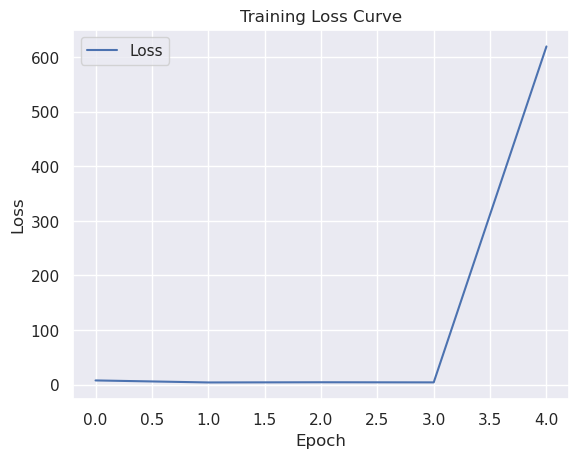

In [10]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a simple classifier (svm) using training representation and corresponding training labels. Finally, use the classifier to do calssification for test representation. Report the acc and auprc.

In [ ]:
from tasks.classification import eval_classification
out, eval_res = eval_classification(
                model,
                train_all,
                train_labels,
                test_all,
                test_labels,
                n_channels,
                encoding_protocol='full_series',
                eval_protocol='svm'
            )
print(eval_res)

In [56]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import LabelEncoder

# # Your data
# # train_repr: shape (n_samples, n_features)
# # train_labels: shape (n_samples,)
# # Encode labels to integers (if not already)
# label_encoder = LabelEncoder()
# labels_encoded = label_encoder.fit_transform(train_labels)

# n_samples = train_repr.shape[0]
# perplexity = min(30, (n_samples - 1) // 3)  # Safe heuristic

# # Run t-SNE
# tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=42)
# embedded = tsne.fit_transform(train_repr)

# # Plot
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(embedded[:, 0], embedded[:, 1], c=labels_encoded, cmap='tab10', s=10)
# plt.colorbar(scatter, ticks=np.unique(labels_encoded))
# plt.title("t-SNE Visualization")
# plt.xlabel("t-SNE-1")
# plt.ylabel("t-SNE-2")
# plt.show()


In [134]:
# print(train_labels)